## Importing Libraries

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

## Part 1: Exploratory Data Analysis

In [2]:
# Creating dataframe from json file
login_df = pd.read_json('logins.json')

In [3]:
# Inspecting the head() of the dataframe
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
# Inspecting the data type of the column
login_df['login_time'].dtype

dtype('<M8[ns]')

In [5]:
login_df['login_count'] = 1

In [6]:
# login_df['Day'] = login_df['login_time'].dt.day

In [7]:
login_df.head()

,login_time,login_count
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [8]:
login_df = login_df.set_index('login_time')

In [9]:
login_df.head()

,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [10]:
# df_log.resample('15T', how='sum')
login_df = login_df.resample('15T').sum()

In [11]:
# sample per day
# login_df[:96].head(96)  # day 1
# login_df[96:192].head(96) # day 2

In [12]:
login_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   login_count  9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


In [13]:
days = {'0': 'Monday','1': 'Tuesday', '2': 'Wednesday', '3': 'Thursday', '4': 'Friday', '5': 'Saturday', '6': 'Sunday'}

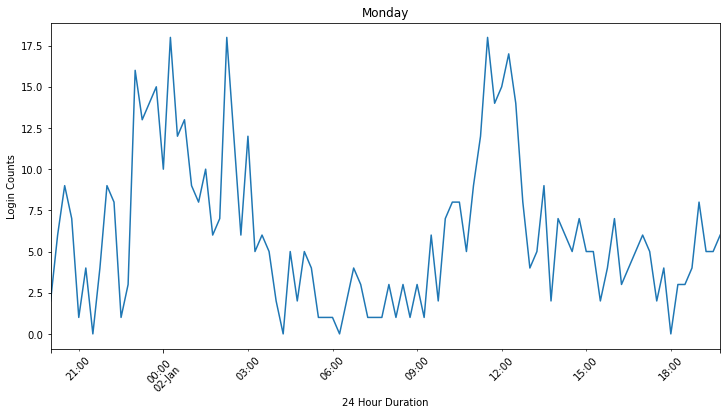

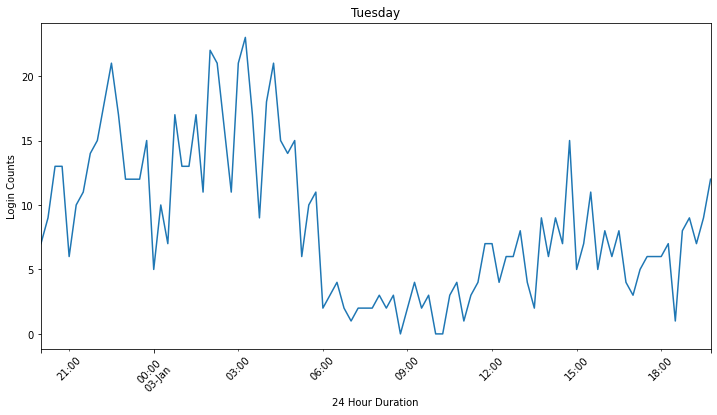

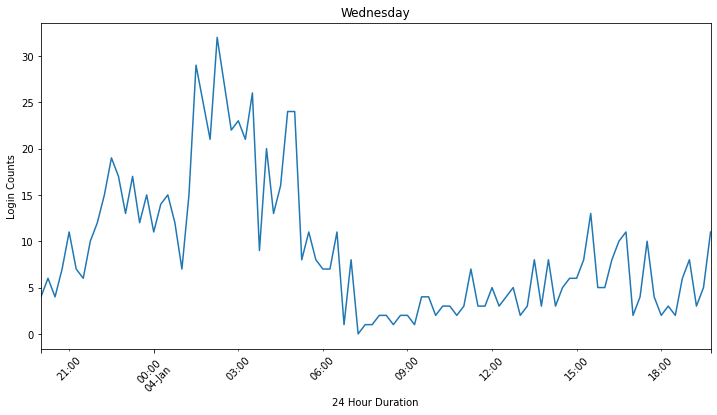

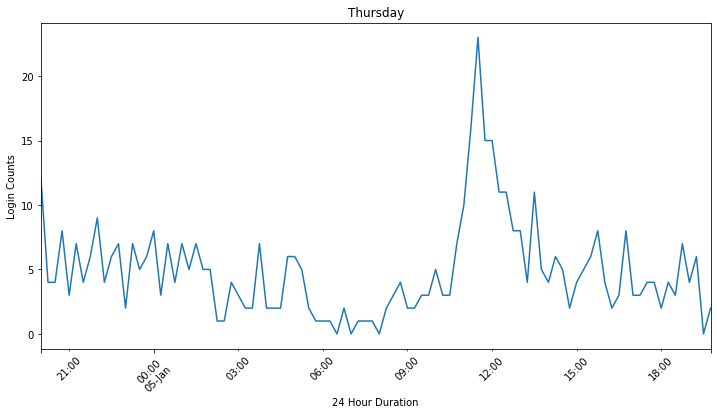

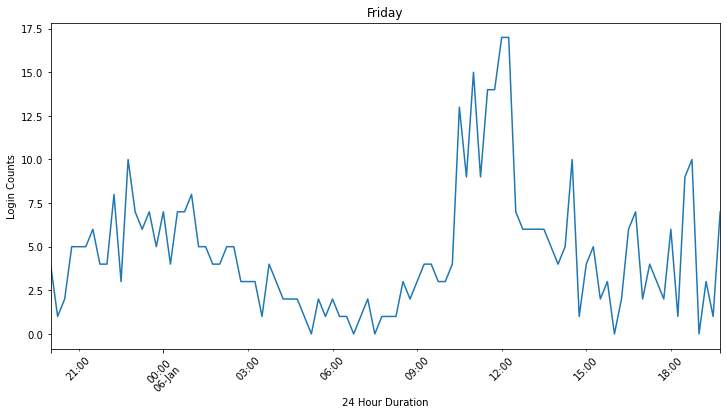

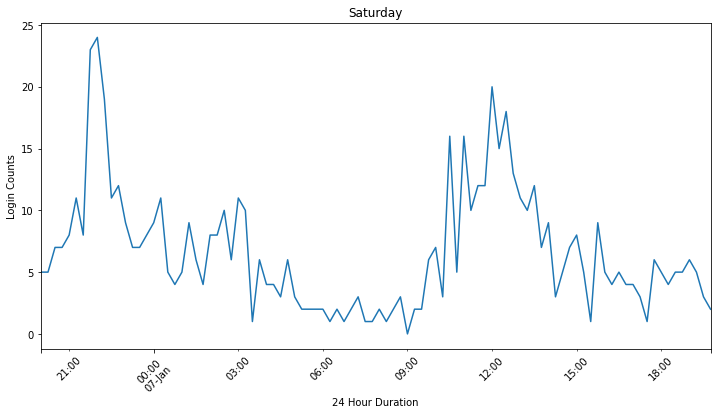

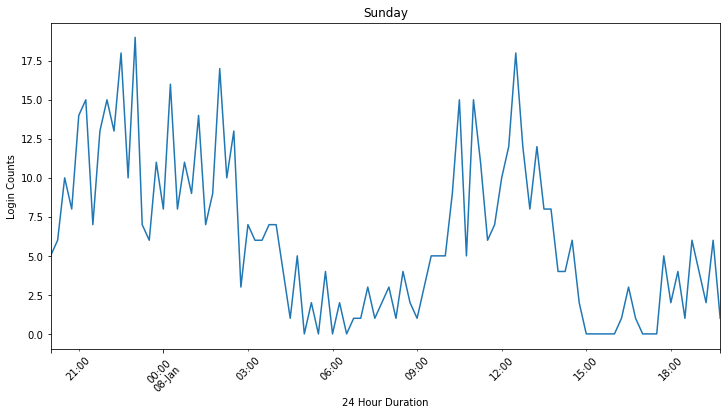

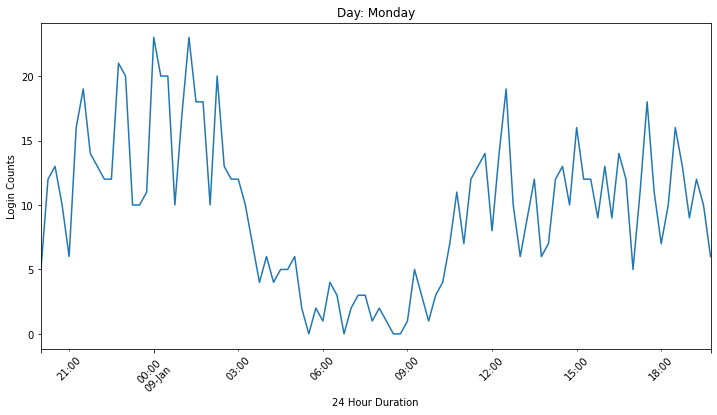

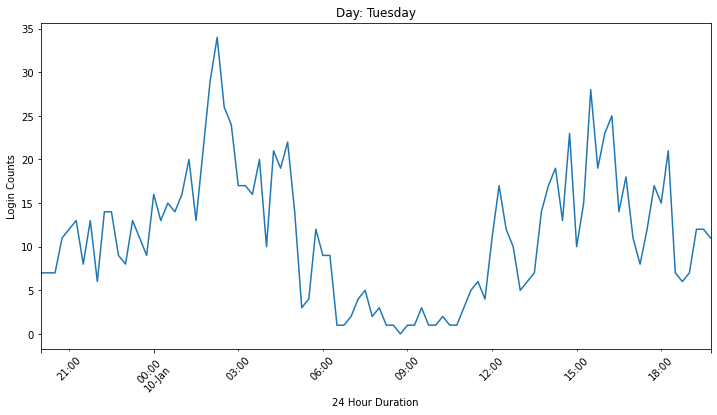

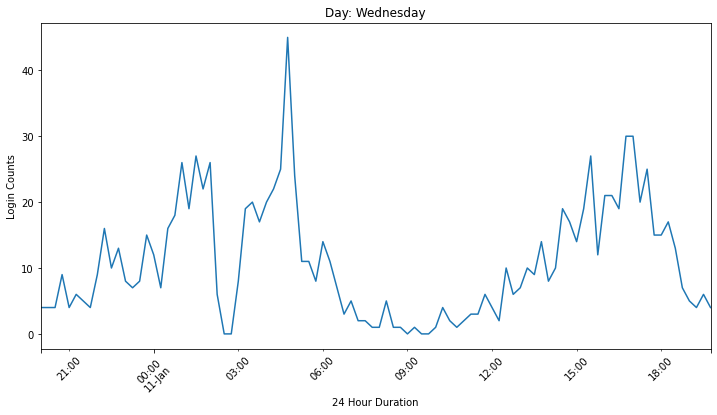

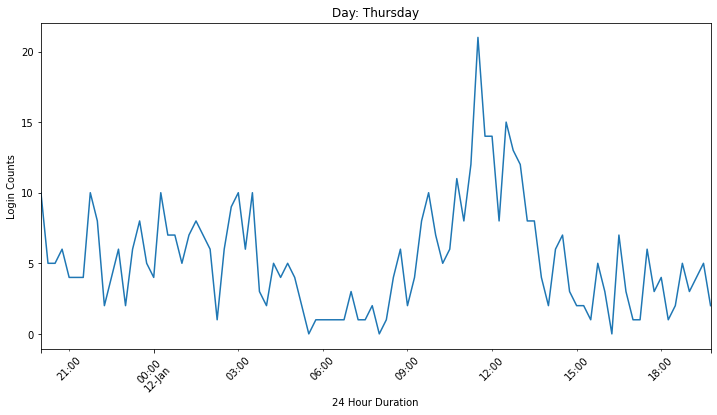

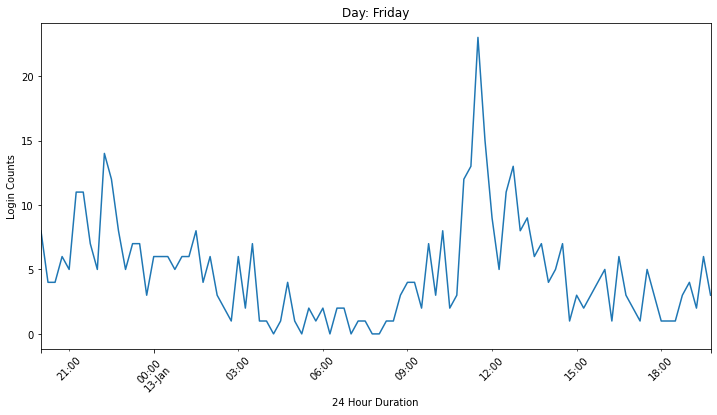

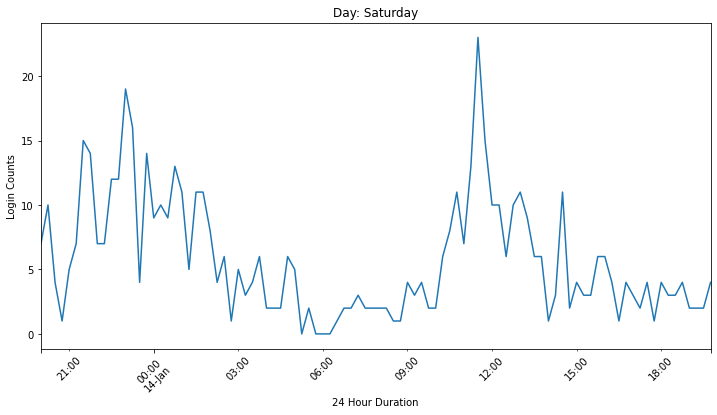

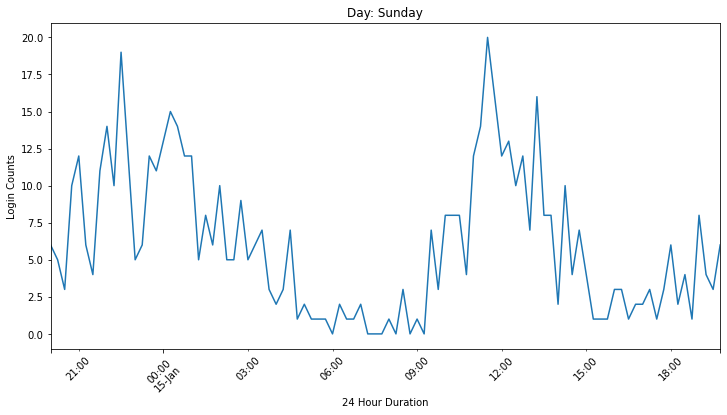

In [14]:
# Visualization of 14 days login count to see the pattern
i = 0
j = 96
for day in range(14):
    plt.figure(figsize=(12,6))
    login_df['login_count'][i:j].plot(rot=45)
    i=j
    j=j+96
    if day<=6:
        plt.title(f"{days[str(day)]}")
        plt.xlabel('24 Hour Duration')
        plt.ylabel('Login Counts')
        plt.show()
    else:
        day_next = day-7
        plt.title(f"Day: {days[str(day_next)]}")
        plt.xlabel('24 Hour Duration')
        plt.ylabel('Login Counts')
        plt.show()


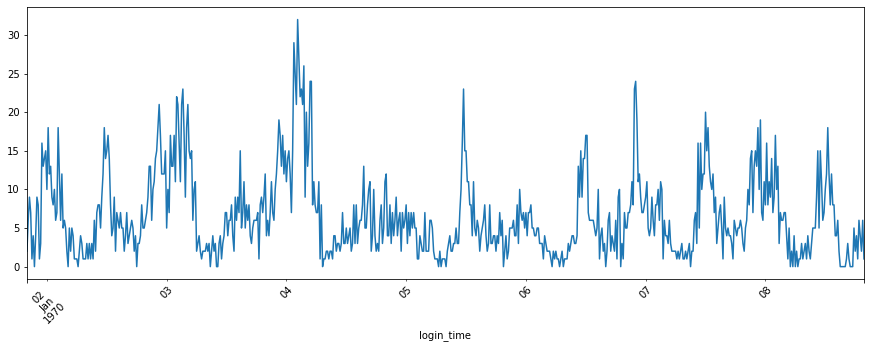

In [15]:
# first week login counts visualization
plt.figure(figsize=(15, 5))
login_df['login_count'][:672].plot(rot=45)
plt.show()

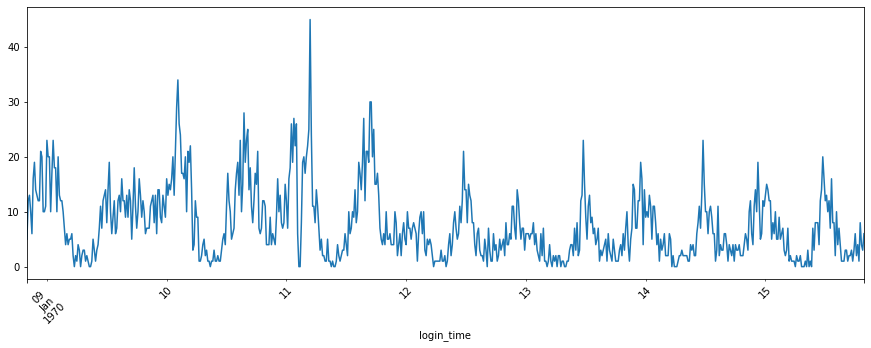

In [16]:
# Second week login counts visualization
plt.figure(figsize=(15, 5))
login_df['login_count'][672:1344].plot(rot=45)
plt.show()

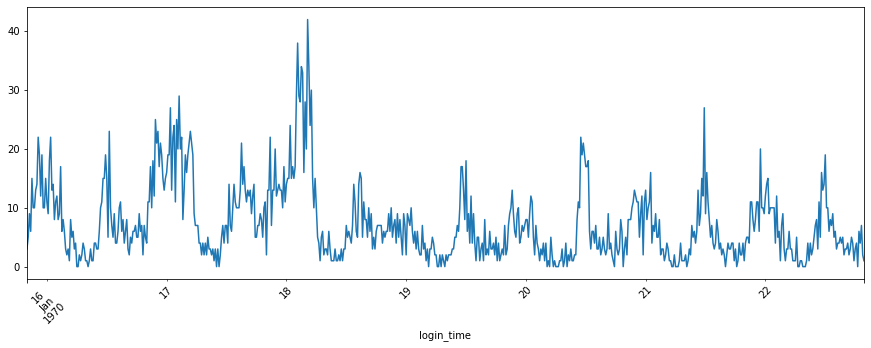

In [17]:
# Third weeks login counts visualization
plt.figure(figsize=(15, 5))
login_df['login_count'][1344:2016].plot(rot=45)
plt.show()

After observing the login counts for 14 consequitive days its visible that there is not similar patter for login counts each day. Although, I have found some similarities of the login counts: 
1. There is no treand ine the data, only exists a weak seasonality
2. Compare to the other days of the week, Wednesday is little bit busy
3. Peak login counts occur at around midnight and at around noon.
4. At morning 6.00 am and evening 6.00 pm each day the login counts reaches at the minimum.
5. There is no significance difference between weekdays and weekend login rates

## Part 2: Experiment and Metric Design

In [18]:
# Print(p) # stop

## Part 3: Predictive Modeling

### Loading data

In [19]:
# Creating dataframe from rider data
rider_df = pd.read_json('ultimate_data_challenge.json')

### Inspecting DataFrame

In [20]:
rider_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [21]:
rider_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


The data type of 'signup_date' and 'last_trip_date' columns is object. I need to change them to 'datatime64' type

In [22]:
rider_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


### Changing data type of some columns

In [23]:
# converting the datatype of 'signup' column to datetime object
rider_df['signup_date'] = pd.to_datetime(rider_df['signup_date'])

In [24]:
# converting the datatype of 'last_trip_date' column to datetime object
rider_df['last_trip_date'] = pd.to_datetime(rider_df['last_trip_date'])

In [25]:
# rider_df.info()

In [26]:
print(f"Early signup date: {rider_df['signup_date'].min()}, last signup date: {rider_df['signup_date'].max()}")

Early signup date: 2014-01-01 00:00:00, last signup date: 2014-01-31 00:00:00


In [27]:
print(f"Early trip date: {rider_df['last_trip_date'].min()}, recent trip date: {rider_df['last_trip_date'].max()}")

Early trip date: 2014-01-01 00:00:00, recent trip date: 2014-07-01 00:00:00


### Creating a new binary column based on 'trips_in_first_30_days' column

In [28]:
# Creating target column based on 'trips_in_first_30_days' column
rider_df['active_status'] = rider_df['trips_in_first_30_days'].apply(lambda x: 0 if x<=0 else 1)

In [29]:
# Inspecting the newly created column
rider_df[['city', 'trips_in_first_30_days', 'active_status']].head()

,city,trips_in_first_30_days,active_status
0,King's Landing,4,1
1,Astapor,0,0
2,Astapor,3,1
3,King's Landing,9,1
4,Winterfell,14,1


In [30]:
rider_df['active_status'].value_counts(normalize=True)

1    0.6922
0    0.3078
Name: active_status, dtype: float64

### Inspecting and filling missing values

In [31]:
rider_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
active_status                0
dtype: int64

#### Filling missing values in phone column based on most common category

In [32]:
rider_df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [33]:
rider_df['phone'].fillna(rider_df['phone'].unique()[0], inplace=True)

#### Filling missing values in 'avg_rating_of_driver' column based on mean rating of active and inactive riders

In [34]:
# mean ratings of driver when active status == 1
active_mean_rating_of_driver = np.mean(rider_df.loc[rider_df['active_status']==1, 'avg_rating_of_driver'])

In [35]:
# mean rating of driver when active status == 0
inactive_mean_rating_of_driver = np.mean(rider_df.loc[rider_df['active_status']==0, 'avg_rating_of_driver'])

In [36]:
# filling missing values on 'avg_rating_of_driver' column based on based on riders active status
rider_df['avg_rating_of_driver'] = rider_df['avg_rating_of_driver'].fillna\
(pd.Series(np.where(rider_df['active_status'] == 1, active_mean_rating_of_driver, inactive_mean_rating_of_driver)))

#### Filling missing values in 'avg_rating_by_driver' column based on mean rating of active and inactive riders

In [37]:
# mean ratings by driver when active status == 1
active_mean_rating_by_driver = np.mean(rider_df.loc[rider_df['active_status']==1, 'avg_rating_by_driver'])

In [38]:
# mean ratings by driver when active status == 0
inactive_mean_rating_by_driver = np.mean(rider_df.loc[rider_df['active_status']==0, 'avg_rating_by_driver'])

In [39]:
# filling missing values on 'avg_rating_by_driver' column based on based on riders active status
rider_df['avg_rating_by_driver'] = rider_df['avg_rating_by_driver'].fillna\
(pd.Series(np.where(rider_df['active_status'] == 1, active_mean_rating_by_driver, inactive_mean_rating_by_driver)))

#### Final missing values checkup

In [40]:
rider_df.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
active_status             0
dtype: int64

In [41]:
rider_df.shape

(50000, 13)

In [42]:
# df.groupby('city')['trips_in_first_30_days'].sum()